In [25]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Load data
df = pd.read_csv('../DATA/DXG.csv')

In [15]:
def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
prices = df['Close'].apply(remove_commas_and_convert)

In [17]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(np.array(prices).reshape(-1, 1))

# Create sequences of data
timesteps = 10
X = []
y = []

for i in range(len(prices) - timesteps):
    X.append(prices[i:i + timesteps])
    y.append(prices[i + timesteps])

X = np.array(X)
y = np.array(y)

# Split the data into train, validation, and test sets (7:2:1)
n_train = int(len(X) * 0.7)
n_val = int(len(X) * 0.2)
n_test = len(X) - n_train - n_val

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

In [19]:
def build_tcn_model(timesteps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

n_features = 1  # Since we have only one feature (the price)
model = build_tcn_model(timesteps, n_features)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 9, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,149 (133.39 KB)

 Trainable params: 34,149 (133.39 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0514 - val_loss: 7.1506e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 2.5873e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 2.3809e-04
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 2.2172e-04
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 2.1403e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 2.1737e-04
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 2.5018e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 1.7892e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.9406e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.5997e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 1.4688e-04
Epoch 12/50
28/28 ━━━━━━━━━━━━

In [21]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2335e-05 
Test Loss: 6.672665767837316e-05


In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted: 13369.1181640625, Actual: 13130.4
Predicted: 13108.73828125, Actual: 12913.000000000002
Predicted: 12872.767578125, Actual: 12434.800000000001
Predicted: 12410.6181640625, Actual: 11956.5
Predicted: 11901.8828125, Actual: 11869.600000000002
Predicted: 11767.7099609375, Actual: 12173.9
Predicted: 12038.400390625, Actual: 12347.8
Predicted: 12271.234375, Actual: 12347.8
Predicted: 12324.93359375, Actual: 12260.9
Predicted: 12251.873046875, Actual: 12000.0
Predicted: 12004.490234375, Actual: 12000.0
Predicted: 11976.8974609375, Actual: 11739.1
Predicted: 11699.3701171875, Actual: 10973.1
Predicted: 10992.9755859375, Actual: 11041.5
Predicted: 10952.640625, Actual: 10323.599999999999
Predicted: 10358.853515625, Actual: 10392.000000000002
Predicted: 10349.5810546875, Actual: 10973.1
Predicted: 10831.416015625, Actual: 11588.4
Predicted: 11509.1591796875, Actual: 12032.8
Predicted: 12087.5263671875, Actual: 12067.0
Predicted: 12184.5107421875,

In [24]:
# Predict the next 30 days
def predict_next_days(model, data, n_days, timesteps):
    predictions = []
    current_seq = data[-timesteps:]
    
    for _ in range(n_days):
        prediction = model.predict(current_seq[np.newaxis, :, :])[0, 0]
        predictions.append(prediction)
        current_seq = np.append(current_seq[1:], [[prediction]], axis=0)
    
    return np.array(predictions)

# Predict the next 30 days
last_sequence = prices[-timesteps:]
predictions_30_days = predict_next_days(model, last_sequence, 30, timesteps)
predictions_30_days = scaler.inverse_transform(predictions_30_days.reshape(-1, 1))

# Print the predictions for the next 30 days
print("Predictions for the next 30 days:")
for i, prediction in enumerate(predictions_30_days):
    print(f"Day {i+1}: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

ValueError: Found array with dim 3. None expected <= 2.

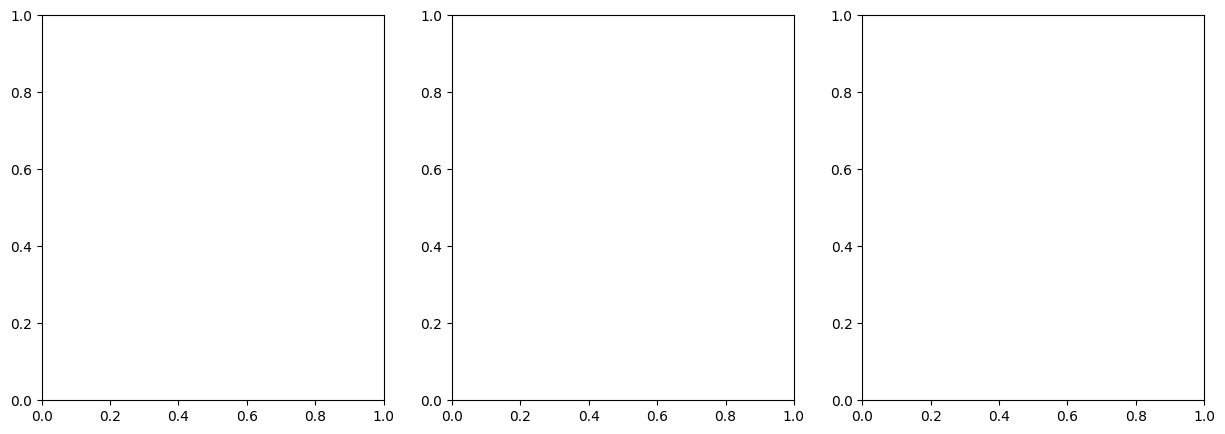

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

vhm_train_data_index = pd.RangeIndex(start=0, stop=n_train, step=1)
axs[2].plot(scaler.inverse_transform(X_train))
vhm_test_data_index = pd.RangeIndex(start=n_train, stop=n_train + n_test, step=1)

axs[2].legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])


axs[2].set_xlabel('VHM',fontsize=20)
plt.tight_layout()
plt.show()